# **1 Data Cleaning and Preprocessing**

In [1]:
import pandas as pd
import re
from dateutil import parser

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
try:
  df=pd.read_pickle("/content/drive/MyDrive/Earnings call prediction/motley-fool-data.pkl")
except Exception as e:
  print(f"Error : {e}")


In [4]:
df.columns

Index(['date', 'exchange', 'q', 'ticker', 'transcript'], dtype='object')

In [5]:
print(f"Data shape: {df.shape}")
df.head(5)

Data shape: (18755, 5)


,date,exchange,q,ticker,transcript
0,"Aug 27, 2020, 9:00 p.m. ET",NASDAQ: BILI,2020-Q2,BILI,"Prepared Remarks:\nOperator\nGood day, and wel..."
1,"Jul 30, 2020, 4:30 p.m. ET",NYSE: GFF,2020-Q3,GFF,Prepared Remarks:\nOperator\nThank you for sta...
2,"Oct 23, 2019, 5:00 p.m. ET",NASDAQ: LRCX,2020-Q1,LRCX,Prepared Remarks:\nOperator\nGood day and welc...
3,"Nov 6, 2019, 12:00 p.m. ET",NASDAQ: BBSI,2019-Q3,BBSI,"Prepared Remarks:\nOperator\nGood day, everyon..."
4,"Aug 7, 2019, 8:30 a.m. ET",NASDAQ: CSTE,2019-Q2,CSTE,Prepared Remarks:\nOperator\nGreetings and wel...


In [6]:
def parse_date(date_str):
  try:
    clean_str=re.sub(r"\sE[DS]?T","",str(date_str))
    return parser.parse(clean_str)
  except:
    return None
df["Timestamp"]=df["date"].apply(parse_date)
df.head(10)

,date,exchange,q,ticker,transcript,Timestamp
0,"Aug 27, 2020, 9:00 p.m. ET",NASDAQ: BILI,2020-Q2,BILI,"Prepared Remarks:\nOperator\nGood day, and wel...",2020-08-27 21:00:00
1,"Jul 30, 2020, 4:30 p.m. ET",NYSE: GFF,2020-Q3,GFF,Prepared Remarks:\nOperator\nThank you for sta...,2020-07-30 16:30:00
2,"Oct 23, 2019, 5:00 p.m. ET",NASDAQ: LRCX,2020-Q1,LRCX,Prepared Remarks:\nOperator\nGood day and welc...,2019-10-23 17:00:00
3,"Nov 6, 2019, 12:00 p.m. ET",NASDAQ: BBSI,2019-Q3,BBSI,"Prepared Remarks:\nOperator\nGood day, everyon...",2019-11-06 12:00:00
4,"Aug 7, 2019, 8:30 a.m. ET",NASDAQ: CSTE,2019-Q2,CSTE,Prepared Remarks:\nOperator\nGreetings and wel...,2019-08-07 08:30:00
5,"Nov 4, 2020, 5:00 p.m. ET",NYSE: GDOT,2020-Q3,GDOT,"Prepared Remarks:\nOperator\nGood afternoon, a...",2020-11-04 17:00:00
6,"Aug 5, 2020, 8:30 a.m. ET",NYSE: KAR,2020-Q2,KAR,Prepared Remarks:\nOperator\nLadies and gentle...,2020-08-05 08:30:00
7,"Mar 24, 2021, 11:00 a.m. ET",NYSE: EPAC,2021-Q2,EPAC,Prepared Remarks:\nOperator\nLadies and gentle...,2021-03-24 11:00:00
8,"Jun 9, 2021, 8:30 a.m. ET",NYSE: ABM,2021-Q2,ABM,Prepared Remarks:\nOperator\nGreetings and wel...,2021-06-09 08:30:00
9,"Aug 11, 2022, 8:30 a.m. ET",NYSE: SGHC,2022-Q2,SGHC,Prepared Remarks:\nOperator\nGood morning and ...,2022-08-11 08:30:00


In [7]:
df=df.dropna(subset=["Timestamp"])
df.shape

(18375, 6)

In [8]:
df["Date_only"]=df["Timestamp"].dt.normalize()
df.head(5)

,date,exchange,q,ticker,transcript,Timestamp,Date_only
0,"Aug 27, 2020, 9:00 p.m. ET",NASDAQ: BILI,2020-Q2,BILI,"Prepared Remarks:\nOperator\nGood day, and wel...",2020-08-27 21:00:00,2020-08-27
1,"Jul 30, 2020, 4:30 p.m. ET",NYSE: GFF,2020-Q3,GFF,Prepared Remarks:\nOperator\nThank you for sta...,2020-07-30 16:30:00,2020-07-30
2,"Oct 23, 2019, 5:00 p.m. ET",NASDAQ: LRCX,2020-Q1,LRCX,Prepared Remarks:\nOperator\nGood day and welc...,2019-10-23 17:00:00,2019-10-23
3,"Nov 6, 2019, 12:00 p.m. ET",NASDAQ: BBSI,2019-Q3,BBSI,"Prepared Remarks:\nOperator\nGood day, everyon...",2019-11-06 12:00:00,2019-11-06
4,"Aug 7, 2019, 8:30 a.m. ET",NASDAQ: CSTE,2019-Q2,CSTE,Prepared Remarks:\nOperator\nGreetings and wel...,2019-08-07 08:30:00,2019-08-07


In [9]:
def clean_transcript(text):
  if not isinstance(text,str):
    return ""
  text = re.sub(r'(Prepared Remarks:|Questions and Answers:)', '', text, flags=re.IGNORECASE)   #headers-Prepared remarks, Q&A
  text = re.sub(r'Operator\n.*?\n', '', text, flags=re.IGNORECASE)   #operator word
  text = re.sub(r'\s+', ' ', text).strip()  #extra whitespace
  return text
df["Clean_Text"]=df['transcript'].apply(clean_transcript)
df["word_count"]=df["Clean_Text"].apply(lambda x: len(str(x).split()))
df=df[df["word_count"]>100]      #keeping text word count >100, deleting short or cancelled calls
output_path="/content/drive/MyDrive/Earnings call prediction/cleaned_transcripts.pkl"
df.to_pickle(output_path)
print(df.shape)
df.head(5)

(18375, 9)


,date,exchange,q,ticker,transcript,Timestamp,Date_only,Clean_Text,word_count
0,"Aug 27, 2020, 9:00 p.m. ET",NASDAQ: BILI,2020-Q2,BILI,"Prepared Remarks:\nOperator\nGood day, and wel...",2020-08-27 21:00:00,2020-08-27,"At this time, I would like to turn the confere...",5623
1,"Jul 30, 2020, 4:30 p.m. ET",NYSE: GFF,2020-Q3,GFF,Prepared Remarks:\nOperator\nThank you for sta...,2020-07-30 16:30:00,2020-07-30,Brian G. Harris -- Senior Vice President and C...,4755
2,"Oct 23, 2019, 5:00 p.m. ET",NASDAQ: LRCX,2020-Q1,LRCX,Prepared Remarks:\nOperator\nGood day and welc...,2019-10-23 17:00:00,2019-10-23,"Tina Correia -- Vice President, Investor Relat...",8917
3,"Nov 6, 2019, 12:00 p.m. ET",NASDAQ: BBSI,2019-Q3,BBSI,"Prepared Remarks:\nOperator\nGood day, everyon...",2019-11-06 12:00:00,2019-11-06,"Joining us today are BBSIs President and CEO, ...",8286
4,"Aug 7, 2019, 8:30 a.m. ET",NASDAQ: CSTE,2019-Q2,CSTE,Prepared Remarks:\nOperator\nGreetings and wel...,2019-08-07 08:30:00,2019-08-07,I would now like to turn the conference over t...,4611


# **2 Stock Price Reaction**

In [10]:
!pip install yfinance

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 49.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 125.8 MB/s eta 0:00:00
  Created wheel for multitasking: filename=multitasking-0.0.12-py3-none-any.whl size=15636 sha256=5ed785509250307598cf0cde54dfecdeaa15fddd9c677bfba243e87e5d6eddf6
  Stored in directory: /root/.cache/pip/wheels/cc/bd/6f/664d62c99327abeef7d86489e6631cbf45b56fbf7ef1d6ef00
  Created wheel for peewee: filename=peewee-3.18.3-cp312-cp312-linux_x86_64.whl size=936697 sha256=4de07e9bdc0988ea19cd4e33f1b2a74820d0fb355f8da567711b3b912bba3c0a
  Stored in directory: /root/.cache/pip/wheels/e2/48/b6/67

In [11]:
import yfinance as yf
from datetime import timedelta
import time
import pandas as pd

In [12]:
df=pd.read_pickle("/content/drive/MyDrive/Earnings call prediction/cleaned_transcripts.pkl")

In [13]:
earliest_date = df['Date_only'].min()
print(f"Earliest Transcript Date found: {earliest_date}")
start_date_dynamic=(earliest_date-pd.Timedelta(days=30)).strftime("%Y-%m-%d")
print(f"Fetching stock history from: {start_date_dynamic}")

Earliest Transcript Date found: 2019-04-11 00:00:00
Fetching stock history from: 2019-03-12


In [14]:
def clean_ticker(ticker_str):
  t=str(ticker_str).upper().strip()
  if ":" in t:    #if ticker is NASDAQ:AAPL
    t=t.split(":")[1].strip()
  t=t.replace("$","")
  return t
df["ticker_clean"]=df['ticker'].apply(clean_ticker)
print(f"unique tickers: {df["ticker_clean"].unique().tolist()}")

unique tickers: ['BILI', 'GFF', 'LRCX', 'BBSI', 'CSTE', 'GDOT', 'KAR', 'EPAC', 'ABM', 'SGHC', 'WDR', 'SJM', 'URBN', 'HESM', 'SPOK', 'TSM', 'MYOV', 'GNW', 'WPP', 'DXCM', 'EME', 'EEFT', 'COUP', 'ARAY', 'WBA', 'ZBRA', 'ROST', 'FL', 'STZ', 'NET', 'HZO', 'LZB', 'USPH', 'MRNA', 'MELI', 'CDNS', 'VIV', 'NTCT', 'U', 'RUSHA', 'DTM', 'VCEL', 'MSTR', 'CSIQ', 'AAPL', 'CENT', 'BCOV', 'FLNT', 'ACLS', 'GEO', 'DFIN', 'GOTU', 'MT', 'SHOP', 'EL', 'LGIH', 'EBS', 'REGN', 'EAF', 'META', 'HRB', 'STRS', 'TTE', 'FCNCA', 'OTIS', 'DHI', 'AIMC', 'HLT', 'TLRY', 'ALGN', 'SGEN', 'F', 'ADNT', 'PPG', 'AL', 'MKL', 'INBK', 'AAWW', 'CARA', 'LILAK', 'SXC', 'CNI', 'BX', 'CMC', 'SIVB', 'GNRC', 'BABA', 'CTIC', 'OPRX', 'XLNX', 'MOD', 'LAMR', 'TRV', 'LOPE', 'OCFT', 'AYX', 'HUN', 'TGT', 'SBSW', 'STNG)', 'WWE', 'DB', 'CHS', 'MRCY', 'AI', 'FCN', 'PSMT', 'LITE', 'HCAT', 'KO', 'CMLS', 'ATC)', 'CTK', 'ZUO', 'OOMA', 'MVIS', 'BJRI', 'AGNC', 'LHCG', 'TTWO', 'AMZN', 'IMOS', 'ROKU', 'CGEN', 'ONTO', 'MNKD', 'HR', 'CLF', 'SIX', 'SITM', 'OL

In [15]:
# This uses 'regex=False' to search for the literal '$' character
print(f"Number of rows in 'ticker_clean' still containing '$': {df['ticker_clean'].str.contains('$', regex=False).sum()}")

Number of rows in 'ticker_clean' still containing '$': 0


In [16]:
price_data={}
def get_price_reaction(row):
  ticker=row["ticker_clean"]
  call_date=row["Date_only"]
  if not ticker or not isinstance(ticker, str): return None
  if ticker not in price_data:
    try:
      stock=yf.Ticker(ticker)
      hist=stock.history(start=start_date_dynamic,end=None)
      if hist.empty:
        price_data[ticker] = None
        return None
      hist.index=hist.index.tz_localize(None)
      price_data[ticker]=hist
    except Exception as e:
      print(f"Error on: {ticker} Error:{e}")
      price_data[ticker]=None
      return None
  hist=price_data[ticker]
  if hist is None or hist.empty:
    return None
  try:
    if call_date<hist.index.min() or call_date>hist.index.max():
      return None
    idx=hist.index.get_indexer([call_date],method="nearest")[0]
    if idx+1>=len(hist):
      return None
    day_0=hist.iloc[idx]
    day_1=hist.iloc[idx+1]
    price_change=(day_1["Close"]-day_0["Open"])/day_0["Open"]
    return price_change
  except Exception:
    return None

print(f"Fetching data")
df["Price_change"]=df.apply(get_price_reaction,axis=1)
df.head(5)

Fetching data


ERROR:yfinance:$WDR: possibly delisted; no timezone found
ERROR:yfinance:$MYOV: possibly delisted; no timezone found
ERROR:yfinance:$COUP: possibly delisted; no timezone found
ERROR:yfinance:$WBA: possibly delisted; no timezone found
ERROR:yfinance:$FL: possibly delisted; no timezone found
ERROR:yfinance:$BCOV: possibly delisted; no timezone found
ERROR:yfinance:$AIMC: possibly delisted; no timezone found
ERROR:yfinance:$SGEN: possibly delisted; no timezone found
ERROR:yfinance:$AAWW: possibly delisted; no timezone found
ERROR:yfinance:$CARA: possibly delisted; no timezone found
ERROR:yfinance:$SIVB: possibly delisted; no timezone found
ERROR:yfinance:$CTIC: possibly delisted; no timezone found
ERROR:yfinance:$XLNX: possibly delisted; no timezone found
ERROR:yfinance:$AYX: possibly delisted; no timezone found
ERROR:yfinance:$STNG): possibly delisted; no timezone found
ERROR:yfinance:$WWE: possibly delisted; no timezone found
ERROR:yfinance:$CHS: possibly delisted; no timezone found
ERR

Error on: SAIC Error:Too Many Requests. Rate limited. Try after a while.
Error on: LESL Error:Too Many Requests. Rate limited. Try after a while.
Error on: XEL Error:Too Many Requests. Rate limited. Try after a while.
Error on: EQT Error:Too Many Requests. Rate limited. Try after a while.
Error on: SUPV Error:Too Many Requests. Rate limited. Try after a while.
Error on: XNET Error:Too Many Requests. Rate limited. Try after a while.
Error on: TUSK Error:Too Many Requests. Rate limited. Try after a while.
Error on: YSG Error:Too Many Requests. Rate limited. Try after a while.
Error on: FNB Error:Too Many Requests. Rate limited. Try after a while.
Error on: AGO Error:Too Many Requests. Rate limited. Try after a while.
Error on: ATR Error:Too Many Requests. Rate limited. Try after a while.
Error on: AMH Error:Too Many Requests. Rate limited. Try after a while.
Error on: PTVE Error:Too Many Requests. Rate limited. Try after a while.
Error on: SRE Error:Too Many Requests. Rate limited. Try a

,date,exchange,q,ticker,transcript,Timestamp,Date_only,Clean_Text,word_count,ticker_clean,Price_change
0,"Aug 27, 2020, 9:00 p.m. ET",NASDAQ: BILI,2020-Q2,BILI,"Prepared Remarks:\nOperator\nGood day, and wel...",2020-08-27 21:00:00,2020-08-27,"At this time, I would like to turn the confere...",5623,BILI,0.035078
1,"Jul 30, 2020, 4:30 p.m. ET",NYSE: GFF,2020-Q3,GFF,Prepared Remarks:\nOperator\nThank you for sta...,2020-07-30 16:30:00,2020-07-30,Brian G. Harris -- Senior Vice President and C...,4755,GFF,0.116154
2,"Oct 23, 2019, 5:00 p.m. ET",NASDAQ: LRCX,2020-Q1,LRCX,Prepared Remarks:\nOperator\nGood day and welc...,2019-10-23 17:00:00,2019-10-23,"Tina Correia -- Vice President, Investor Relat...",8917,LRCX,0.142022
3,"Nov 6, 2019, 12:00 p.m. ET",NASDAQ: BBSI,2019-Q3,BBSI,"Prepared Remarks:\nOperator\nGood day, everyon...",2019-11-06 12:00:00,2019-11-06,"Joining us today are BBSIs President and CEO, ...",8286,BBSI,0.029891
4,"Aug 7, 2019, 8:30 a.m. ET",NASDAQ: CSTE,2019-Q2,CSTE,Prepared Remarks:\nOperator\nGreetings and wel...,2019-08-07 08:30:00,2019-08-07,I would now like to turn the conference over t...,4611,CSTE,0.249623


In [17]:
num_failed_fetches = df['Price_change'].isnull().sum()
print(f"Number of rows where Price_change could not be fetched: {num_failed_fetches}")

Number of rows where Price_change could not be fetched: 7462


In [18]:
df_cleaned = df.dropna(subset=['Price_change']).copy()
print(f"New DataFrame shape after dropping rows: {df_cleaned.shape}")

New DataFrame shape after dropping rows: (10913, 11)


In [19]:
df.head(5)

,date,exchange,q,ticker,transcript,Timestamp,Date_only,Clean_Text,word_count,ticker_clean,Price_change
0,"Aug 27, 2020, 9:00 p.m. ET",NASDAQ: BILI,2020-Q2,BILI,"Prepared Remarks:\nOperator\nGood day, and wel...",2020-08-27 21:00:00,2020-08-27,"At this time, I would like to turn the confere...",5623,BILI,0.035078
1,"Jul 30, 2020, 4:30 p.m. ET",NYSE: GFF,2020-Q3,GFF,Prepared Remarks:\nOperator\nThank you for sta...,2020-07-30 16:30:00,2020-07-30,Brian G. Harris -- Senior Vice President and C...,4755,GFF,0.116154
2,"Oct 23, 2019, 5:00 p.m. ET",NASDAQ: LRCX,2020-Q1,LRCX,Prepared Remarks:\nOperator\nGood day and welc...,2019-10-23 17:00:00,2019-10-23,"Tina Correia -- Vice President, Investor Relat...",8917,LRCX,0.142022
3,"Nov 6, 2019, 12:00 p.m. ET",NASDAQ: BBSI,2019-Q3,BBSI,"Prepared Remarks:\nOperator\nGood day, everyon...",2019-11-06 12:00:00,2019-11-06,"Joining us today are BBSIs President and CEO, ...",8286,BBSI,0.029891
4,"Aug 7, 2019, 8:30 a.m. ET",NASDAQ: CSTE,2019-Q2,CSTE,Prepared Remarks:\nOperator\nGreetings and wel...,2019-08-07 08:30:00,2019-08-07,I would now like to turn the conference over t...,4611,CSTE,0.249623


In [20]:
original_df_path="/content/drive/MyDrive/Earnings call prediction/original_stock_price_reaction.csv"
final_df_path="/content/drive/MyDrive/Earnings call prediction/cleaned_stock_price_reaction.csv"   #for model training
df.to_csv(original_df_path,index=False)
df_cleaned.to_csv(final_df_path,index=False)

# **3 Exploratory Data Analysis**

In [21]:
import pandas as pd
import numpy as np

In [22]:
df_analysis=pd.read_csv("/content/drive/MyDrive/Earnings call prediction/cleaned_stock_price_reaction.csv")
df_analysis.head(5)

,date,exchange,q,ticker,transcript,Timestamp,Date_only,Clean_Text,word_count,ticker_clean,Price_change
0,"Aug 27, 2020, 9:00 p.m. ET",NASDAQ: BILI,2020-Q2,BILI,"Prepared Remarks:\nOperator\nGood day, and wel...",2020-08-27 21:00:00,2020-08-27,"At this time, I would like to turn the confere...",5623,BILI,0.035078
1,"Jul 30, 2020, 4:30 p.m. ET",NYSE: GFF,2020-Q3,GFF,Prepared Remarks:\nOperator\nThank you for sta...,2020-07-30 16:30:00,2020-07-30,Brian G. Harris -- Senior Vice President and C...,4755,GFF,0.116154
2,"Oct 23, 2019, 5:00 p.m. ET",NASDAQ: LRCX,2020-Q1,LRCX,Prepared Remarks:\nOperator\nGood day and welc...,2019-10-23 17:00:00,2019-10-23,"Tina Correia -- Vice President, Investor Relat...",8917,LRCX,0.142022
3,"Nov 6, 2019, 12:00 p.m. ET",NASDAQ: BBSI,2019-Q3,BBSI,"Prepared Remarks:\nOperator\nGood day, everyon...",2019-11-06 12:00:00,2019-11-06,"Joining us today are BBSIs President and CEO, ...",8286,BBSI,0.029891
4,"Aug 7, 2019, 8:30 a.m. ET",NASDAQ: CSTE,2019-Q2,CSTE,Prepared Remarks:\nOperator\nGreetings and wel...,2019-08-07 08:30:00,2019-08-07,I would now like to turn the conference over t...,4611,CSTE,0.249623


In [23]:
print(df_analysis.shape)
df_analysis.columns

(10913, 11)


Index(['date', 'exchange', 'q', 'ticker', 'transcript', 'Timestamp',
       'Date_only', 'Clean_Text', 'word_count', 'ticker_clean',
       'Price_change'],
      dtype='object')

In [24]:
df_analysis['Price_change'].describe()

,Price_change
count,10913.000000
mean,-0.000077
std,0.080863
min,-0.609143
25%,-0.038139
50%,-0.000344
75%,0.037409
max,0.715686


In [25]:
extreme_gain_count=df_analysis[df_analysis["Price_change"]>0.1].shape[0]
extreme_loss_count=df_analysis[df_analysis["Price_change"]<-0.1].shape[0]
print(f"No. of Earning calls resulting extreme gain : {extreme_gain_count}")
print(f"No. of Earning calls resulting extreme loss : {extreme_loss_count}")

No. of Earning calls resulting extreme gain : 883
No. of Earning calls resulting extreme loss : 862


In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

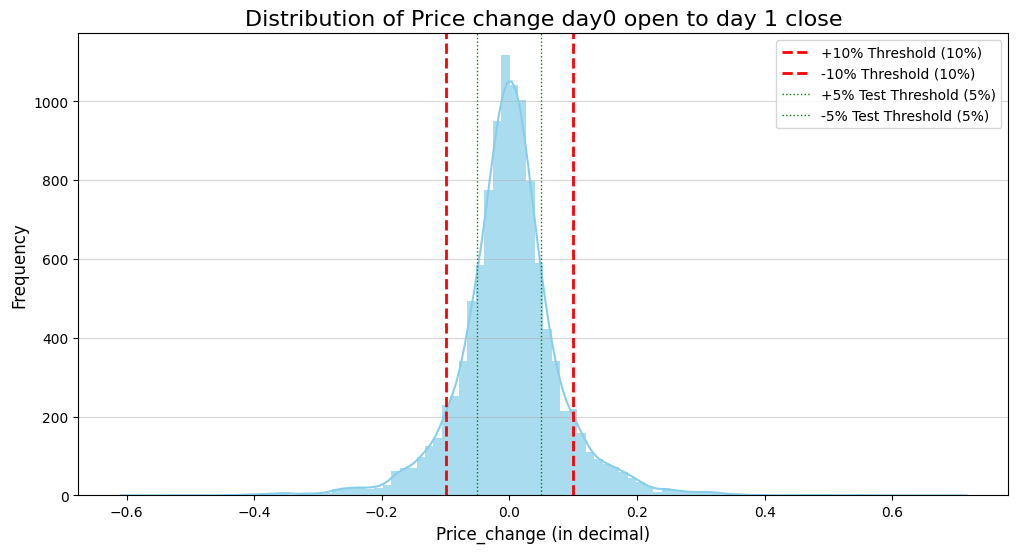

In [27]:
CURRENT_THRESHOLD = 0.10
LOWER_THRESHOLD = 0.05

plt.figure(figsize=(12,6))
sns.histplot(df_analysis["Price_change"],bins=100,kde=True,edgecolor="none",color="skyblue",alpha=0.7)
plt.axvline(CURRENT_THRESHOLD,color="red",linestyle="--",linewidth=2,label=f"+{CURRENT_THRESHOLD*100:.0f}% Threshold (10%)")
plt.axvline(-CURRENT_THRESHOLD,color="red",linestyle="--",linewidth=2,label=f"-{CURRENT_THRESHOLD*100:.0f}% Threshold (10%)")

plt.axvline(LOWER_THRESHOLD,color="green",linestyle=":",linewidth=1,label=f"+{LOWER_THRESHOLD*100:.0f}% Test Threshold (5%)")
plt.axvline(-LOWER_THRESHOLD,color="green",linestyle=":",linewidth=1,label=f"-{LOWER_THRESHOLD*100:.0f}% Test Threshold (5%)")

plt.title("Distribution of Price change day0 open to day 1 close",fontsize=16)
plt.xlabel("Price_change (in decimal)",fontsize=12)
plt.ylabel("Frequency",fontsize=12)
plt.grid(axis="y",alpha=0.5)
plt.legend()
plt.show()

In [28]:
THRESHOLD=0.05
conditions=[(df_analysis["Price_change"]>=THRESHOLD), (df_analysis["Price_change"]<=-THRESHOLD)]
values=["Gain","Loss"]
df_analysis["Target_Class"]=np.select(condlist=conditions,choicelist=values,default="Neutral")
print("Target_Class column created")

Target_Class column created


In [29]:
class_distribution_counts=df_analysis['Target_Class'].value_counts()
class_distribution_percent=class_distribution_counts.apply(lambda x:f"{(x/class_distribution_counts.sum())*100:2f}%")
print(f"class_distribution_counts are {class_distribution_counts}")
print(f"Class distribution percentage are {class_distribution_percent}")

class_distribution_counts are Target_Class
Neutral    6621
Loss       2186
Gain       2106
Name: count, dtype: int64
Class distribution percentage are Target_Class
Neutral    60.670760%
Loss       20.031156%
Gain       19.298085%
Name: count, dtype: object


# **4 Feature Engineering**

**Temporal Features**

In [30]:
df_analysis['Date_only']=pd.to_datetime(df_analysis["Date_only"])
df_analysis["DateOfWeek"]=df_analysis["Date_only"].dt.day_of_week
df_analysis["Month"]=df_analysis["Date_only"].dt.month
df_analysis["Quarter"]=df_analysis["Date_only"].dt.quarter

**bold text**

In [31]:
!pip install category_encoders
from category_encoders import TargetEncoder

df_analysis["Target_gain_flag"]=(df_analysis["Target_Class"]=="Gain").astype(int)
encoder=TargetEncoder(cols=["ticker_clean"])
df_analysis["Ticker_gain_prob"]=encoder.fit_transform(df_analysis["ticker_clean"],df_analysis["Target_gain_flag"])

df_analysis["Target_loss_flag"]=(df_analysis["Target_Class"]=="Loss").astype(int)
encoder=TargetEncoder(cols=["ticker_clean"])
df_analysis["Ticker_loss_prob"]=encoder.fit_transform(df_analysis["ticker_clean"],df_analysis["Target_loss_flag"])
df_analysis.head(5)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.9/85.9 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.3/233.3 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 144.9 MB/s eta 0:00:00


,date,exchange,q,ticker,transcript,Timestamp,Date_only,Clean_Text,word_count,ticker_clean,Price_change,Target_Class,DateOfWeek,Month,Quarter,Target_gain_flag,Ticker_gain_prob,Target_loss_flag,Ticker_loss_prob
0,"Aug 27, 2020, 9:00 p.m. ET",NASDAQ: BILI,2020-Q2,BILI,"Prepared Remarks:\nOperator\nGood day, and wel...",2020-08-27 21:00:00,2020-08-27,"At this time, I would like to turn the confere...",5623,BILI,0.035078,Neutral,3,8,3,0,0.137200,0,0.221243
1,"Jul 30, 2020, 4:30 p.m. ET",NYSE: GFF,2020-Q3,GFF,Prepared Remarks:\nOperator\nThank you for sta...,2020-07-30 16:30:00,2020-07-30,Brian G. Harris -- Senior Vice President and C...,4755,GFF,0.116154,Gain,3,7,3,1,0.212841,0,0.218602
2,"Oct 23, 2019, 5:00 p.m. ET",NASDAQ: LRCX,2020-Q1,LRCX,Prepared Remarks:\nOperator\nGood day and welc...,2019-10-23 17:00:00,2019-10-23,"Tina Correia -- Vice President, Investor Relat...",8917,LRCX,0.142022,Gain,2,10,4,1,0.264048,0,0.182879
3,"Nov 6, 2019, 12:00 p.m. ET",NASDAQ: BBSI,2019-Q3,BBSI,"Prepared Remarks:\nOperator\nGood day, everyon...",2019-11-06 12:00:00,2019-11-06,"Joining us today are BBSIs President and CEO, ...",8286,BBSI,0.029891,Neutral,2,11,4,0,0.212841,0,0.188007
4,"Aug 7, 2019, 8:30 a.m. ET",NASDAQ: CSTE,2019-Q2,CSTE,Prepared Remarks:\nOperator\nGreetings and wel...,2019-08-07 08:30:00,2019-08-07,I would now like to turn the conference over t...,4611,CSTE,0.249623,Gain,2,8,3,1,0.255781,0,0.205784


In [32]:
df_analysis.drop(columns=["Target_gain_flag","Target_loss_flag","ticker_clean"],inplace=True)
df_analysis.head(5)

,date,exchange,q,ticker,transcript,Timestamp,Date_only,Clean_Text,word_count,Price_change,Target_Class,DateOfWeek,Month,Quarter,Ticker_gain_prob,Ticker_loss_prob
0,"Aug 27, 2020, 9:00 p.m. ET",NASDAQ: BILI,2020-Q2,BILI,"Prepared Remarks:\nOperator\nGood day, and wel...",2020-08-27 21:00:00,2020-08-27,"At this time, I would like to turn the confere...",5623,0.035078,Neutral,3,8,3,0.137200,0.221243
1,"Jul 30, 2020, 4:30 p.m. ET",NYSE: GFF,2020-Q3,GFF,Prepared Remarks:\nOperator\nThank you for sta...,2020-07-30 16:30:00,2020-07-30,Brian G. Harris -- Senior Vice President and C...,4755,0.116154,Gain,3,7,3,0.212841,0.218602
2,"Oct 23, 2019, 5:00 p.m. ET",NASDAQ: LRCX,2020-Q1,LRCX,Prepared Remarks:\nOperator\nGood day and welc...,2019-10-23 17:00:00,2019-10-23,"Tina Correia -- Vice President, Investor Relat...",8917,0.142022,Gain,2,10,4,0.264048,0.182879
3,"Nov 6, 2019, 12:00 p.m. ET",NASDAQ: BBSI,2019-Q3,BBSI,"Prepared Remarks:\nOperator\nGood day, everyon...",2019-11-06 12:00:00,2019-11-06,"Joining us today are BBSIs President and CEO, ...",8286,0.029891,Neutral,2,11,4,0.212841,0.188007
4,"Aug 7, 2019, 8:30 a.m. ET",NASDAQ: CSTE,2019-Q2,CSTE,Prepared Remarks:\nOperator\nGreetings and wel...,2019-08-07 08:30:00,2019-08-07,I would now like to turn the conference over t...,4611,0.249623,Gain,2,8,3,0.255781,0.205784


In [33]:
path="/content/drive/MyDrive/Earnings call prediction/final_dataframe_after_FE.csv"
df_analysis.to_csv(path)

**Sentiment scores**

In [34]:
import pandas as pd
import numpy as np

In [36]:
df_analysis=pd.read_csv("/content/drive/MyDrive/Earnings call prediction/final_dataframe_after_FE.csv")

In [37]:
!pip install transformers torch tqdm
! pip install torch==2.9.0 'torch_xla[tpu]==2.9.0' -f https://storage.googleapis.com/libtpu-releases/index.html
import torch_xla.core.xla_model as xm
import torch
device = xm.xla_device()
print("TPU device connected:", device)
t1 = torch.randn(3, 3, device=device)
t2 = torch.randn(3, 3, device=device)
print("\nExample computation on TPU:", t1 + t2)

import torch
from transformers import pipeline
from tqdm.auto import tqdm
import pandas as pd

classifier = pipeline("text-classification", model="ProsusAI/finbert", return_all_scores=True, device=device)

# Preparing Data
texts = df_analysis['Clean_Text'].astype(str).tolist()
batch_size = 32
results = []

print(f"Starting inference on {len(texts)} rows...")
for i in tqdm(range(0, len(texts), batch_size)):
  batch = texts[i : i + batch_size]
  batch_results = classifier(batch, truncation=True, max_length=512)
  results.extend(batch_results)

# Parsing Results into Columns. FinBERT outputs a list of dictionaries. Mapping them to columns
pos_scores = []
neg_scores = []
neu_scores = []

for row_result in results:
  scores_dict = {item['label']: item['score'] for item in row_result}
  pos_scores.append(scores_dict.get('positive', 0))
  neg_scores.append(scores_dict.get('negative', 0))
  neu_scores.append(scores_dict.get('neutral', 0))

#Adding to DataFrame
df_analysis['FinBERT_Positive'] = pos_scores
df_analysis['FinBERT_Negative'] = neg_scores
df_analysis['FinBERT_Neutral'] = neu_scores

df_analysis.drop(columns=['Clean_Text'], inplace=True)

print("Success! FinBERT scores added.")

Looking in links: https://storage.googleapis.com/libtpu-releases/index.html
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.8/149.8 MB 2.7 MB/s eta 0:00:00
  Attempting uninstall: libtpu
    Found existing installation: libtpu 0.0.17
    Uninstalling libtpu-0.0.17:
      Successfully uninstalled libtpu-0.0.17


/tmp/ipython-input-3842202340.py:5: DeprecationWarning: Use torch_xla.device instead
  device = xm.xla_device()


TPU device connected: xla:0

Example computation on TPU: tensor([[ 0.3355, -1.4628, -3.2610],
        [-1.4656,  0.3196, -2.8766],
        [ 0.8667, -1.5060,  0.7125]], device='xla:0')


/usr/local/lib/python3.12/dist-packages/jax/_src/cloud_tpu_init.py:86: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use xla:0


Starting inference on 10913 rows...


/usr/local/lib/python3.12/dist-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


  0%|          | 0/342 [00:00<?, ?it/s]

Success! FinBERT scores added.


In [38]:
df_analysis.head(5)

,Unnamed: 0,date,exchange,q,ticker,transcript,Timestamp,Date_only,word_count,Price_change,Target_Class,DateOfWeek,Month,Quarter,Ticker_gain_prob,Ticker_loss_prob,FinBERT_Positive,FinBERT_Negative,FinBERT_Neutral
0,0,"Aug 27, 2020, 9:00 p.m. ET",NASDAQ: BILI,2020-Q2,BILI,"Prepared Remarks:\nOperator\nGood day, and wel...",2020-08-27 21:00:00,2020-08-27,5623,0.035078,Neutral,3,8,3,0.137200,0.221243,0.146988,0.012653,0.840358
1,1,"Jul 30, 2020, 4:30 p.m. ET",NYSE: GFF,2020-Q3,GFF,Prepared Remarks:\nOperator\nThank you for sta...,2020-07-30 16:30:00,2020-07-30,4755,0.116154,Gain,3,7,3,0.212841,0.218602,0.910005,0.010605,0.079389
2,2,"Oct 23, 2019, 5:00 p.m. ET",NASDAQ: LRCX,2020-Q1,LRCX,Prepared Remarks:\nOperator\nGood day and welc...,2019-10-23 17:00:00,2019-10-23,8917,0.142022,Gain,2,10,4,0.264048,0.182879,0.878131,0.012376,0.109493
3,3,"Nov 6, 2019, 12:00 p.m. ET",NASDAQ: BBSI,2019-Q3,BBSI,"Prepared Remarks:\nOperator\nGood day, everyon...",2019-11-06 12:00:00,2019-11-06,8286,0.029891,Neutral,2,11,4,0.212841,0.188007,0.727205,0.122016,0.150779
4,4,"Aug 7, 2019, 8:30 a.m. ET",NASDAQ: CSTE,2019-Q2,CSTE,Prepared Remarks:\nOperator\nGreetings and wel...,2019-08-07 08:30:00,2019-08-07,4611,0.249623,Gain,2,8,3,0.255781,0.205784,0.755221,0.136653,0.108126


In [39]:
df_analysis.columns

Index(['Unnamed: 0', 'date', 'exchange', 'q', 'ticker', 'transcript',
       'Timestamp', 'Date_only', 'word_count', 'Price_change', 'Target_Class',
       'DateOfWeek', 'Month', 'Quarter', 'Ticker_gain_prob',
       'Ticker_loss_prob', 'FinBERT_Positive', 'FinBERT_Negative',
       'FinBERT_Neutral'],
      dtype='object')

In [40]:
df_analysis.drop(columns=['Unnamed: 0',"Ticker_gain_prob","Ticker_loss_prob"],inplace=True)
df_analysis.head(5)

,date,exchange,q,ticker,transcript,Timestamp,Date_only,word_count,Price_change,Target_Class,DateOfWeek,Month,Quarter,FinBERT_Positive,FinBERT_Negative,FinBERT_Neutral
0,"Aug 27, 2020, 9:00 p.m. ET",NASDAQ: BILI,2020-Q2,BILI,"Prepared Remarks:\nOperator\nGood day, and wel...",2020-08-27 21:00:00,2020-08-27,5623,0.035078,Neutral,3,8,3,0.146988,0.012653,0.840358
1,"Jul 30, 2020, 4:30 p.m. ET",NYSE: GFF,2020-Q3,GFF,Prepared Remarks:\nOperator\nThank you for sta...,2020-07-30 16:30:00,2020-07-30,4755,0.116154,Gain,3,7,3,0.910005,0.010605,0.079389
2,"Oct 23, 2019, 5:00 p.m. ET",NASDAQ: LRCX,2020-Q1,LRCX,Prepared Remarks:\nOperator\nGood day and welc...,2019-10-23 17:00:00,2019-10-23,8917,0.142022,Gain,2,10,4,0.878131,0.012376,0.109493
3,"Nov 6, 2019, 12:00 p.m. ET",NASDAQ: BBSI,2019-Q3,BBSI,"Prepared Remarks:\nOperator\nGood day, everyon...",2019-11-06 12:00:00,2019-11-06,8286,0.029891,Neutral,2,11,4,0.727205,0.122016,0.150779
4,"Aug 7, 2019, 8:30 a.m. ET",NASDAQ: CSTE,2019-Q2,CSTE,Prepared Remarks:\nOperator\nGreetings and wel...,2019-08-07 08:30:00,2019-08-07,4611,0.249623,Gain,2,8,3,0.755221,0.136653,0.108126


In [41]:
def clean_ticker(ticker_str):
  t=str(ticker_str).upper().strip()
  if ":" in t:    #if ticker is NASDAQ:AAPL
    t=t.split(":")[1].strip()
  t=t.replace("$","")
  return t
df_analysis["ticker_clean"]=df_analysis['ticker'].apply(clean_ticker)
print(f"unique tickers: {df_analysis["ticker_clean"].unique().tolist()}")

unique tickers: ['BILI', 'GFF', 'LRCX', 'BBSI', 'CSTE', 'GDOT', 'KAR', 'EPAC', 'ABM', 'SGHC', 'SJM', 'URBN', 'HESM', 'SPOK', 'TSM', 'GNW', 'WPP', 'DXCM', 'EME', 'EEFT', 'ARAY', 'ZBRA', 'ROST', 'STZ', 'NET', 'HZO', 'LZB', 'USPH', 'MRNA', 'MELI', 'CDNS', 'VIV', 'NTCT', 'U', 'RUSHA', 'DTM', 'VCEL', 'MSTR', 'CSIQ', 'AAPL', 'CENT', 'FLNT', 'ACLS', 'GEO', 'DFIN', 'GOTU', 'MT', 'SHOP', 'EL', 'LGIH', 'EBS', 'REGN', 'EAF', 'META', 'HRB', 'STRS', 'TTE', 'FCNCA', 'OTIS', 'DHI', 'HLT', 'TLRY', 'ALGN', 'F', 'ADNT', 'PPG', 'AL', 'MKL', 'INBK', 'LILAK', 'SXC', 'CNI', 'BX', 'CMC', 'GNRC', 'BABA', 'OPRX', 'MOD', 'LAMR', 'TRV', 'LOPE', 'OCFT', 'HUN', 'TGT', 'SBSW', 'DB', 'MRCY', 'AI', 'FCN', 'PSMT', 'LITE', 'HCAT', 'KO', 'CMLS', 'OOMA', 'MVIS', 'BJRI', 'AGNC', 'TTWO', 'AMZN', 'IMOS', 'ROKU', 'CGEN', 'ONTO', 'MNKD', 'HR', 'CLF', 'SITM', 'OLED', 'COHR', 'ABR', 'WGO', 'APAM', 'CASH', 'MSA', 'GPI', 'CYD', 'ZEUS', 'WFC', 'NGD', 'PRI', 'CB', 'ANET', 'ARRY', 'SEER', 'KMB', 'GPRO', 'VVV', 'SNAP', 'OKTA', 'NUE',

In [42]:
df_analysis.head(5)

,date,exchange,q,ticker,transcript,Timestamp,Date_only,word_count,Price_change,Target_Class,DateOfWeek,Month,Quarter,FinBERT_Positive,FinBERT_Negative,FinBERT_Neutral,ticker_clean
0,"Aug 27, 2020, 9:00 p.m. ET",NASDAQ: BILI,2020-Q2,BILI,"Prepared Remarks:\nOperator\nGood day, and wel...",2020-08-27 21:00:00,2020-08-27,5623,0.035078,Neutral,3,8,3,0.146988,0.012653,0.840358,BILI
1,"Jul 30, 2020, 4:30 p.m. ET",NYSE: GFF,2020-Q3,GFF,Prepared Remarks:\nOperator\nThank you for sta...,2020-07-30 16:30:00,2020-07-30,4755,0.116154,Gain,3,7,3,0.910005,0.010605,0.079389,GFF
2,"Oct 23, 2019, 5:00 p.m. ET",NASDAQ: LRCX,2020-Q1,LRCX,Prepared Remarks:\nOperator\nGood day and welc...,2019-10-23 17:00:00,2019-10-23,8917,0.142022,Gain,2,10,4,0.878131,0.012376,0.109493,LRCX
3,"Nov 6, 2019, 12:00 p.m. ET",NASDAQ: BBSI,2019-Q3,BBSI,"Prepared Remarks:\nOperator\nGood day, everyon...",2019-11-06 12:00:00,2019-11-06,8286,0.029891,Neutral,2,11,4,0.727205,0.122016,0.150779,BBSI
4,"Aug 7, 2019, 8:30 a.m. ET",NASDAQ: CSTE,2019-Q2,CSTE,Prepared Remarks:\nOperator\nGreetings and wel...,2019-08-07 08:30:00,2019-08-07,4611,0.249623,Gain,2,8,3,0.755221,0.136653,0.108126,CSTE


In [43]:
df_analysis.columns

Index(['date', 'exchange', 'q', 'ticker', 'transcript', 'Timestamp',
       'Date_only', 'word_count', 'Price_change', 'Target_Class', 'DateOfWeek',
       'Month', 'Quarter', 'FinBERT_Positive', 'FinBERT_Negative',
       'FinBERT_Neutral', 'ticker_clean'],
      dtype='object')

In [46]:
path="/content/drive/MyDrive/Earnings call prediction/Dataframe_after_finbert.csv"
df_analysis.to_csv(path,index=False)

In [47]:
from sklearn.model_selection import train_test_split, TimeSeriesSplit
df_analysis = df_analysis.sort_values(by='Date_only').reset_index(drop=True)
cols_to_drop = [
    "Target_Class",
    "Price_change",
    "Date_only",
    "date",
    "Timestamp",
    "transcript",
    "exchange",
    "q",
    "ticker",
    "word_count"
]

X = df_analysis.drop(columns=[c for c in cols_to_drop if c in df_analysis.columns])
y = df_analysis["Target_Class"]

test_size = 0.3
split_index = int(len(df_analysis) * (1 - test_size))

X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]
y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]

print(f"Training data size: {len(X_train)}")
print(f"Test data size: {len(X_test)}")
print("\nFinal Features in X_train:", X_train.columns.tolist())

Training data size: 7639
Test data size: 3274

Final Features in X_train: ['DateOfWeek', 'Month', 'Quarter', 'FinBERT_Positive', 'FinBERT_Negative', 'FinBERT_Neutral', 'ticker_clean']


In [49]:
import pandas as pd
train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)
train_path="/content/drive/MyDrive/Earnings call prediction/train_dataset.csv"
test_path="/content/drive/MyDrive/Earnings call prediction/test_dataset.csv"
train_df.to_csv(train_path, index=False)
test_df.to_csv(test_path, index=False)

print("Train and Test datasets saved successfully!")
print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")

Train and Test datasets saved successfully!
Train shape: (7639, 8)
Test shape: (3274, 8)


In [50]:
!pip install category_encoders
from category_encoders import TargetEncoder

gain_encoder = TargetEncoder(cols=['ticker_clean'])
loss_encoder = TargetEncoder(cols=['ticker_clean'])

y_train_gain = (y_train == 'Gain').astype(int)
y_train_loss = (y_train == 'Loss').astype(int)

# FITTING on X_train, TRANSFORM X_train
X_train['Ticker_Gain_Prob'] = gain_encoder.fit_transform(X_train['ticker_clean'], y_train_gain)
X_train['Ticker_Loss_Prob'] = loss_encoder.fit_transform(X_train['ticker_clean'], y_train_loss)

# TRANSFORM X_test
X_test['Ticker_Gain_Prob'] = gain_encoder.transform(X_test['ticker_clean'])
X_test['Ticker_Loss_Prob'] = loss_encoder.transform(X_test['ticker_clean'])

X_train.drop(columns=['ticker_clean'], inplace=True)
X_test.drop(columns=['ticker_clean'], inplace=True)

print("Target Encoding done correctly! No data leakage.")
print("X_train columns:", X_train.columns.tolist())

Target Encoding done correctly! No data leakage.
X_train columns: ['DateOfWeek', 'Month', 'Quarter', 'FinBERT_Positive', 'FinBERT_Negative', 'FinBERT_Neutral', 'Ticker_Gain_Prob', 'Ticker_Loss_Prob']


/tmp/ipython-input-2961120192.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['Ticker_Gain_Prob'] = gain_encoder.fit_transform(X_train['ticker_clean'], y_train_gain)
/tmp/ipython-input-2961120192.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['Ticker_Loss_Prob'] = loss_encoder.fit_transform(X_train['ticker_clean'], y_train_loss)
/tmp/ipython-input-2961120192.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

# **5.Feature Scaling**

In [51]:
from sklearn.preprocessing import StandardScaler
import joblib

scaler = StandardScaler()

# Fitting on Train, Transforming Train
X_train_scaled = scaler.fit_transform(X_train)
# Transforming Test
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)
print("Data Scaling Complete.")

# SAVING THE COMPONENTS for Streamlit ---
# Save Encoders
joblib.dump(gain_encoder, 'ticker_gain_encoder.joblib')
joblib.dump(loss_encoder, 'ticker_loss_encoder.joblib')
# Save Scaler (
joblib.dump(scaler, 'standard_scaler.joblib')

print("Encoders and Scaler saved to .joblib files.")

Data Scaling Complete.
Encoders and Scaler saved to .joblib files.


In [53]:
import pandas as pd

train_final_df=X_train_scaled.copy()
test_final_df=X_test_scaled.copy()

# Adding the Target column to them to save
train_final_df['Target_Class'] = y_train.reset_index(drop=True)
test_final_df['Target_Class'] = y_test.reset_index(drop=True)

train_final_df.to_csv("/content/drive/MyDrive/Earnings call prediction/train_scaled_ready.csv", index=False)
test_final_df.to_csv("/content/drive/MyDrive/Earnings call prediction/test_scaled_ready.csv", index=False)

print("Scaled data saved! You are safe to start Hyperparameter Tuning.")

Scaled data saved! You are safe to start Hyperparameter Tuning.


# **6 Model Training**

In [54]:
!pip install xgboost
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
import joblib

# Encoding Target Labels (Gain/Loss/Neutral -> 0/1/2)
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# Saving the Label Encoder for streamlit
joblib.dump(le, 'target_label_encoder.joblib')
print("Target Labels encoded and encoder saved.")

tscv = TimeSeriesSplit(n_splits=5)
# Hyperparameter Grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6, 8],
    'min_child_weight': [1, 3, 5, 7],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2]
}

# Initializing the Model
xgb = XGBClassifier(
    objective='multi:softprob',
    num_class=3,
    random_state=42,
    eval_metric='mlogloss'
)

#Randomized Search
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_grid,
    n_iter=50,
    scoring='f1_weighted',
    cv=tscv,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

print("Starting Hyperparameter Tuning...")
random_search.fit(X_train_scaled, y_train_encoded)

print("\nTuning Complete!")
print(f"Best Parameters: {random_search.best_params_}")
print(f"Best Weighted F1-Score: {random_search.best_score_:.4f}")

# Saving the Best Model
best_model = random_search.best_estimator_
joblib.dump(best_model, 'final_xgb_model.joblib')
print("Best model saved as 'final_xgb_model.joblib'")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.8/296.8 MB 1.3 MB/s eta 0:00:00
Target Labels encoded and encoder saved.
Starting Hyperparameter Tuning...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Tuning Complete!
Best Parameters: {'subsample': 0.8, 'n_estimators': 100, 'min_child_weight': 5, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 1.0}
Best Weighted F1-Score: 0.6936
Best model saved as 'final_xgb_model.joblib'


In [55]:
X_train_scaled.shape

(7639, 8)

# **7 Model Testing and Evaluation**


--- FINAL CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

        Gain       0.31      0.20      0.24       738
        Loss       0.35      0.26      0.30       805
     Neutral       0.61      0.78      0.68      1731

    accuracy                           0.52      3274
   macro avg       0.42      0.41      0.41      3274
weighted avg       0.48      0.52      0.49      3274



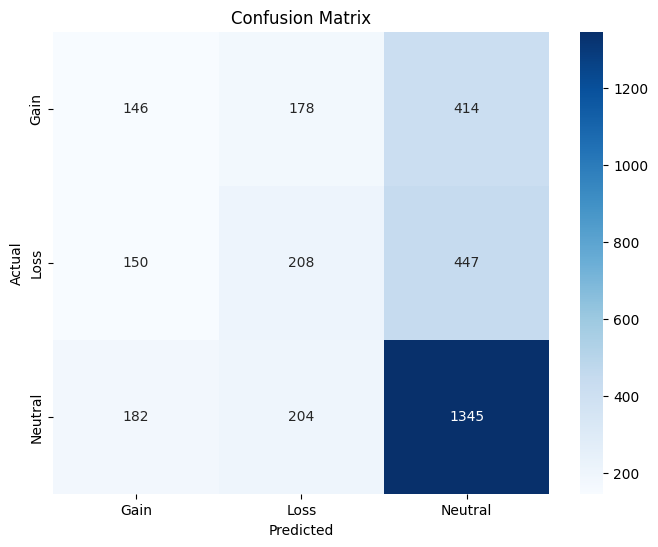

In [56]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = best_model.predict(X_test_scaled)
# Converting numerical predictions back to labels (0/1/2 -> Gain/Loss/Neutral)
y_test_decoded = le.inverse_transform(y_test_encoded)
y_pred_decoded = le.inverse_transform(y_pred)

print("\n--- FINAL CLASSIFICATION REPORT ---")
print(classification_report(y_test_decoded, y_pred_decoded))

cm = confusion_matrix(y_test_decoded, y_pred_decoded, labels=['Gain', 'Loss', 'Neutral'])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Gain', 'Loss', 'Neutral'],
            yticklabels=['Gain', 'Loss', 'Neutral'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# **8 Feature Importance**

/tmp/ipython-input-895659390.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10), palette='viridis')


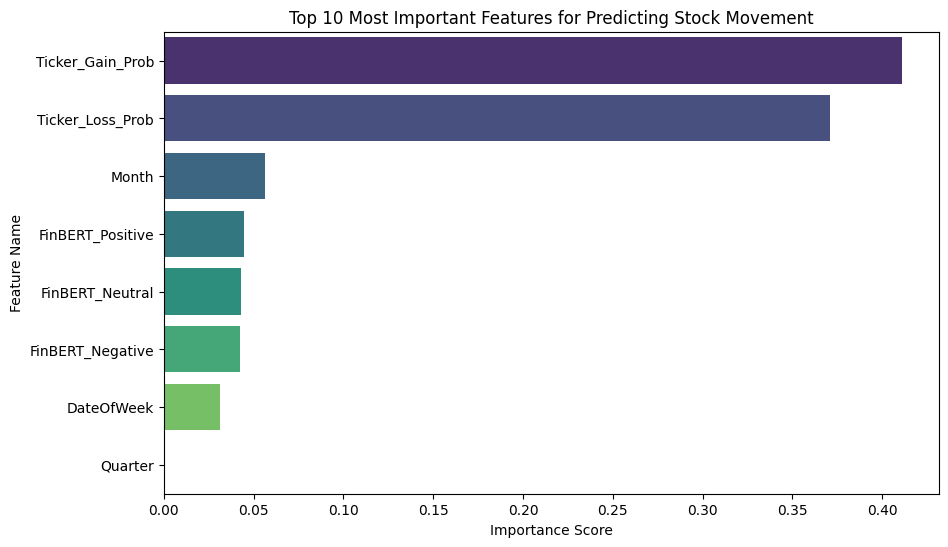

            Feature  Importance
6  Ticker_Gain_Prob    0.411073
7  Ticker_Loss_Prob    0.371030
1             Month    0.056265
3  FinBERT_Positive    0.044843
5   FinBERT_Neutral    0.043177
4  FinBERT_Negative    0.042573
0        DateOfWeek    0.031039
2           Quarter    0.000000


In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
importances = best_model.feature_importances_

# Mapping scores to column names
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Visualize
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10), palette='viridis')
plt.title('Top 10 Most Important Features for Predicting Stock Movement')
plt.xlabel('Importance Score')
plt.ylabel('Feature Name')
plt.show()

# Printing the raw data
print(feature_importance_df.head(10))

# **10 Threshold Tuning**

Class Order: ['Gain' 'Loss' 'Neutral']


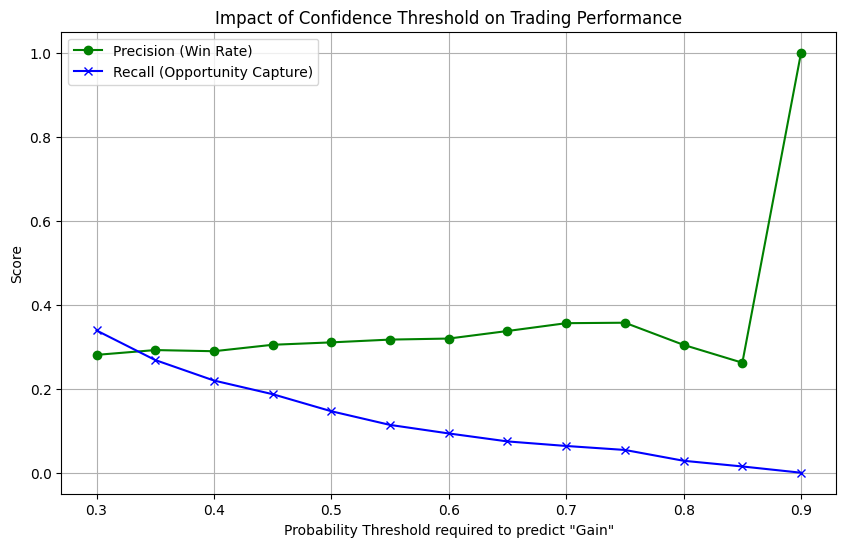

Threshold: 0.30 | Precision: 0.28 | Recall: 0.34
Threshold: 0.35 | Precision: 0.29 | Recall: 0.27
Threshold: 0.40 | Precision: 0.29 | Recall: 0.22
Threshold: 0.45 | Precision: 0.30 | Recall: 0.19
Threshold: 0.50 | Precision: 0.31 | Recall: 0.15
Threshold: 0.55 | Precision: 0.32 | Recall: 0.11
Threshold: 0.60 | Precision: 0.32 | Recall: 0.09
Threshold: 0.65 | Precision: 0.34 | Recall: 0.07
Threshold: 0.70 | Precision: 0.36 | Recall: 0.06
Threshold: 0.75 | Precision: 0.36 | Recall: 0.05
Threshold: 0.80 | Precision: 0.30 | Recall: 0.03
Threshold: 0.85 | Precision: 0.26 | Recall: 0.01
Threshold: 0.90 | Precision: 1.00 | Recall: 0.00


In [58]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score

# Getting Probabilities instead of Class Labels
# This returns an array with 3 columns: [Prob_Gain, Prob_Loss, Prob_Neutral]
y_probs = best_model.predict_proba(X_test_scaled)

print(f"Class Order: {le.classes_}")
gain_index = np.where(le.classes_ == 'Gain')[0][0]

# Testing Thresholds from 0.3 to 0.9
thresholds = np.arange(0.3, 0.95, 0.05)
precisions = []
recalls = []

# Ground truth for Gain (Binary: 1 if Gain, 0 if Loss/Neutral)
y_test_gain_binary = (y_test_decoded == 'Gain').astype(int)

for t in thresholds:
    # If Prob_Gain > t, predict 1, else 0
    custom_preds = (y_probs[:, gain_index] >= t).astype(int)
    # Calculating scores
    if np.sum(custom_preds) > 0: # Avoid division by zero
        p = precision_score(y_test_gain_binary, custom_preds)
        r = recall_score(y_test_gain_binary, custom_preds)
    else:
        p = 1.0
        r = 0.0

    precisions.append(p)
    recalls.append(r)

# Plotting the Trade-off of Precision and Recall
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precision (Win Rate)', marker='o', color='green')
plt.plot(thresholds, recalls, label='Recall (Opportunity Capture)', marker='x', color='blue')
plt.title('Impact of Confidence Threshold on Trading Performance')
plt.xlabel('Probability Threshold required to predict "Gain"')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()


for t, p, r in zip(thresholds, precisions, recalls):
    print(f"Threshold: {t:.2f} | Precision: {p:.2f} | Recall: {r:.2f}")

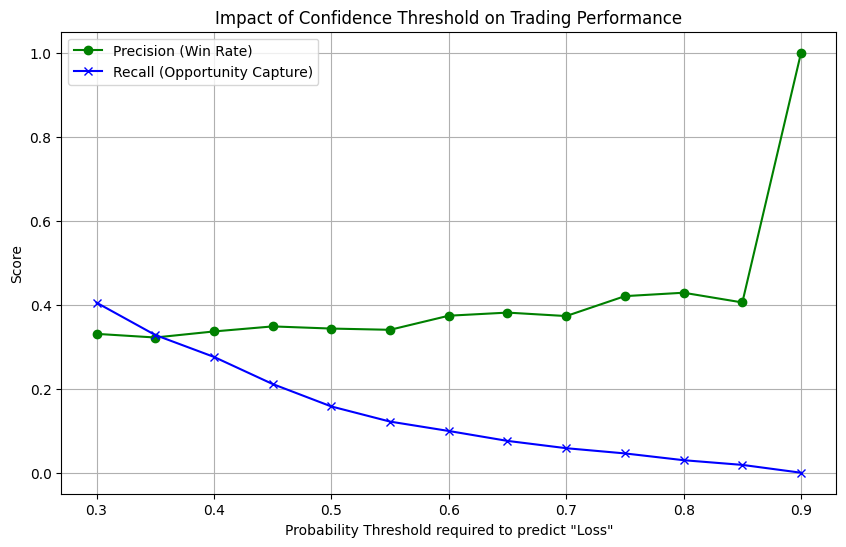

Threshold: 0.30 | Precision: 0.33 | Recall: 0.40
Threshold: 0.35 | Precision: 0.32 | Recall: 0.33
Threshold: 0.40 | Precision: 0.34 | Recall: 0.28
Threshold: 0.45 | Precision: 0.35 | Recall: 0.21
Threshold: 0.50 | Precision: 0.34 | Recall: 0.16
Threshold: 0.55 | Precision: 0.34 | Recall: 0.12
Threshold: 0.60 | Precision: 0.37 | Recall: 0.10
Threshold: 0.65 | Precision: 0.38 | Recall: 0.08
Threshold: 0.70 | Precision: 0.37 | Recall: 0.06
Threshold: 0.75 | Precision: 0.42 | Recall: 0.05
Threshold: 0.80 | Precision: 0.43 | Recall: 0.03
Threshold: 0.85 | Precision: 0.41 | Recall: 0.02
Threshold: 0.90 | Precision: 1.00 | Recall: 0.00


In [61]:
loss_index = np.where(le.classes_ == 'Loss')[0][0]

# Testing Thresholds from 0.3 to 0.9
thresholds = np.arange(0.3, 0.95, 0.05)
precisions = []
recalls = []

# Ground truth for Gain (Binary: 1 if Gain, 0 if Loss/Neutral)
y_test_loss_binary = (y_test_decoded == 'Loss').astype(int)

for t in thresholds:
    # If Prob_Gain > t, predict 1, else 0
    custom_preds = (y_probs[:, loss_index] >= t).astype(int)
    # Calculating scores
    if np.sum(custom_preds) > 0: # Avoid division by zero
        p = precision_score(y_test_loss_binary, custom_preds)
        r = recall_score(y_test_loss_binary, custom_preds)
    else:
        p = 1.0
        r = 0.0

    precisions.append(p)
    recalls.append(r)

# Plotting the Trade-off of Precision and Recall
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precision (Win Rate)', marker='o', color='green')
plt.plot(thresholds, recalls, label='Recall (Opportunity Capture)', marker='x', color='blue')
plt.title('Impact of Confidence Threshold on Trading Performance')
plt.xlabel('Probability Threshold required to predict "Loss"')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()


for t, p, r in zip(thresholds, precisions, recalls):
    print(f"Threshold: {t:.2f} | Precision: {p:.2f} | Recall: {r:.2f}")

**Download Files and get versions for Streamlit**

In [59]:
import os
import zipfile
from IPython.display import FileLink

files_to_download = [
    'final_xgb_model.joblib',
    'standard_scaler.joblib',
    'target_label_encoder.joblib',
    'ticker_gain_encoder.joblib',
    'ticker_loss_encoder.joblib',
    'cleaned_stock_data.csv'
]

zip_filename = 'project_artifacts.zip'

print(f"Zipping {len(files_to_download)} files into '{zip_filename}'...")
missing_files = []

with zipfile.ZipFile(zip_filename, 'w') as zipf:
    for file in files_to_download:
        if os.path.exists(file):
            zipf.write(file)
            print(f"  - Added: {file}")
        else:
            missing_files.append(file)
            print(f"Warning: '{file}' not found. Did you save it?")

if len(missing_files) == len(files_to_download):
    print("\nError: No files found to zip. Please re-run the saving steps.")
else:
    print(f"\nZip file created: {zip_filename}")
    try:
        from google.colab import files
        files.download(zip_filename)
        print("Downloading via Google Colab...")
    except ImportError:
        print("Kaggle Detected. Click the link below to download:")
        display(FileLink(zip_filename))

Zipping 6 files into 'project_artifacts.zip'...
  - Added: final_xgb_model.joblib
  - Added: standard_scaler.joblib
  - Added: target_label_encoder.joblib
  - Added: ticker_gain_encoder.joblib
  - Added: ticker_loss_encoder.joblib

Zip file created: project_artifacts.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [60]:
import xgboost
import sklearn
import joblib
print(f"XGBoost Version: {xgboost.__version__}")
print(f"Scikit-Learn Version: {sklearn.__version__}")
print(f"Joblib Version: {joblib.__version__}")

XGBoost Version: 3.1.2
Scikit-Learn Version: 1.6.1
Joblib Version: 1.5.2
